In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [5]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

# Load datasets

kaggle_df = pd.read_csv('/Users/khushi/Desktop/kag.csv')
myo_df = pd.read_csv('/Users/khushi/Desktop/myo.csv')


In [6]:
#Delete time on kaggle
kaggle_df = kaggle_df.drop('time', axis=1)

kaggle_df

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,-1.0,-3.0,0.0,-3.0,-3.0,0.0,0.0,-2.0,0.0
1,0.0,2.0,-1.0,1.0,4.0,-1.0,-1.0,-2.0,0.0
2,3.0,1.0,4.0,2.0,6.0,2.0,10.0,12.0,0.0
3,-2.0,-2.0,0.0,7.0,-1.0,4.0,-30.0,-2.0,0.0
4,-2.0,-2.0,3.0,-3.0,1.0,-1.0,-2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1749049,9.0,1.0,3.0,1.0,-3.0,-8.0,4.0,0.0,6.0
1749050,9.0,1.0,3.0,1.0,-3.0,-8.0,4.0,0.0,6.0
1749051,9.0,1.0,3.0,1.0,-3.0,-8.0,4.0,0.0,6.0
1749052,14.0,3.0,-1.0,1.0,-12.0,6.0,-7.0,-13.0,6.0


In [7]:
#Rename columns
myo_df.columns = [f'channel{str(i)}' if col.startswith('EMG') else col for i, col in enumerate(myo_df.columns, 1)]

print(myo_df.columns)


Index(['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6',
       'channel7', 'channel8', 'class'],
      dtype='object')


In [8]:
# Define the EMG channels 
emg_columns = [f"channel{i}" for i in range(1, 9)]

# Normalize 
scaler = StandardScaler()


kaggle_df[emg_columns] = scaler.fit_transform(kaggle_df[emg_columns])
myo_df[emg_columns] = scaler.fit_transform(myo_df[emg_columns])


print("Kaggle class column unique values:", kaggle_df['class'].unique())
print("MYO class column unique values:", myo_df['class'].unique())



Kaggle class column unique values: [0. 1. 2. 3. 4. 5. 6.]
MYO class column unique values: [1 0 2 3 5 4]


In [9]:
# Split datasets
X_kaggle = kaggle_df[emg_columns].values
y_kaggle = kaggle_df['class'].values


X_myo = myo_df[emg_columns].values
y_myo = myo_df['class'].values

# Reshape the data 
X_kaggle = X_kaggle.reshape((X_kaggle.shape[0], 1, X_kaggle.shape[1]))  # (batch_size, 1, 8)
X_myo = X_myo.reshape((X_myo.shape[0], 1, X_myo.shape[1]))  # (batch_size, 1, 8)


X_train_kaggle, X_val_kaggle, y_train_kaggle, y_val_kaggle = train_test_split(X_kaggle, y_kaggle, test_size=0.2, random_state=42)



In [10]:
# Define Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)  # Ensure output dimension matches embed_dim (which is 8)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # Attention and residual connection
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network and residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Ensure the output has the same dimension as the input
        return self.layernorm2(out1 + ffn_output)

# Define the Transformer model
def build_transformer_model(input_shape, num_classes, embed_dim=8, num_heads=4, ff_dim=32, num_blocks=2, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Apply Transformer blocks
    x = layers.InputLayer(input_shape=input_shape)(inputs)
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, rate)(x)
    
    # Pooling and output layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Build model for Kaggle dataset 
input_shape = (X_kaggle.shape[1], X_kaggle.shape[2])  # (1, 8)
num_classes_kaggle = len(kaggle_df['class'].unique())
model_kaggle = build_transformer_model(input_shape, num_classes_kaggle)

# Compile the model
model_kaggle.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model 
model_kaggle.fit(X_train_kaggle, y_train_kaggle, epochs=10, batch_size=32, validation_data=(X_val_kaggle, y_val_kaggle))


for layer in model_kaggle.layers[:-2]:  # Freeze all layers except last ones
    layer.trainable = False

# Compile the model again before fine-tuning
model_kaggle.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model on MYO dataset (6 classes)
model_kaggle.fit(X_myo, y_myo, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model on MYO dataset 
test_loss, test_acc = model_kaggle.evaluate(X_myo, y_myo)
print(f"Test accuracy after fine-tuning on MYO dataset: {test_acc}")


2025-02-21 16:06:53.356959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
43727/43727 [==============================] - 125s 3ms/step - loss: 1.3559 - accuracy: 0.4717 - val_loss: 1.2357 - val_accuracy: 0.5203
Epoch 2/10
43727/43727 [==============================] - 124s 3ms/step - loss: 1.3208 - accuracy: 0.4914 - val_loss: 1.2360 - val_accuracy: 0.5213
Epoch 3/10
43727/43727 [==============================] - 122s 3ms/step - loss: 1.3149 - accuracy: 0.4942 - val_loss: 1.2198 - val_accuracy: 0.5301
Epoch 4/10
43727/43727 [==============================] - 132s 3ms/step - loss: 1.3108 - accuracy: 0.4962 - val_loss: 1.2165 - val_accuracy: 0.5290
Epoch 5/10
43727/43727 [==============================] - 133s 3ms/step - loss: 1.3092 - accuracy: 0.4975 - val_loss: 1.2126 - val_accuracy: 0.5298
Epoch 6/10
43727/43727 [==============================] - 132s 3ms/step - loss: 1.3073 - accuracy: 0.4983 - val_loss: 1.2141 - val_accuracy: 0.5296
Epoch 7/10
43727/43727 [==============================] - 123s 3ms/step - loss: 1.3064 - accuracy: 0.4992 - val_

465/465 [==============================] - 1s 1ms/step


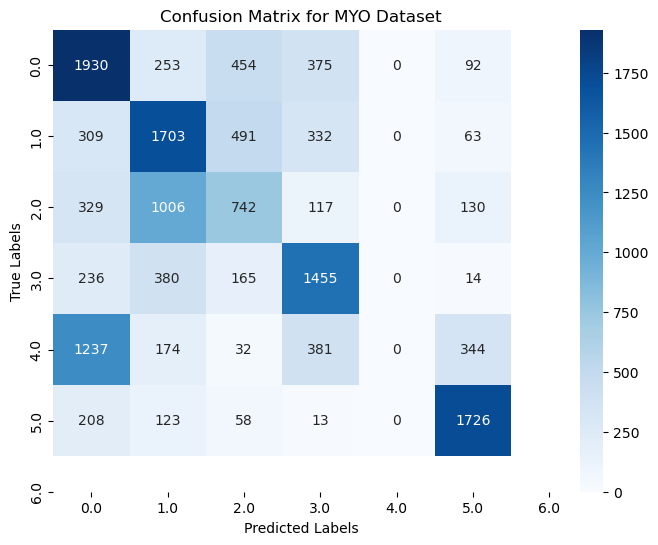

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the MYO dataset
y_pred_myo = model_kaggle.predict(X_myo)
y_pred_myo = tf.argmax(y_pred_myo, axis=1).numpy() 

#confusion matrix
conf_matrix = confusion_matrix(y_myo, y_pred_myo)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=kaggle_df['class'].unique(), yticklabels=kaggle_df['class'].unique())
plt.title('Confusion Matrix for MYO Dataset')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [12]:
from sklearn.metrics import confusion_matrix, classification_report



# classification report (precision, recall, F1 score)
class_report = classification_report(y_myo, y_pred_myo, target_names=[str(c) for c in myo_df['class'].unique()])
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           1       0.45      0.62      0.52      3104
           0       0.47      0.59      0.52      2898
           2       0.38      0.32      0.35      2324
           3       0.54      0.65      0.59      2250
           5       0.00      0.00      0.00      2168
           4       0.73      0.81      0.77      2128

    accuracy                           0.51     14872
   macro avg       0.43      0.50      0.46     14872
weighted avg       0.43      0.51      0.46     14872



/Users/khushi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/khushi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/khushi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
